Step1:First, install and import the required libraries

In [ ]:
pip install tensorflow scikit-learn matplotlib numpy


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt

Load the Olivetti Faces dataset

In [ ]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces(shuffle=True, random_state=42)


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


Split the dataset into training and test sets

In [ ]:
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
# Reshape the input data to 2D images
X = X.reshape(-1, 64, 64, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


 Encode the labels

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


Define the Siamese network architecture

In [ ]:
def create_siamese_model(input_shape):
    input = keras.layers.Input(shape=input_shape)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu')(input)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    output = keras.layers.Dense(64)(x)
    return keras.Model(input, output)


 Create Siamese model with shared weights

In [ ]:
input_shape = X_train[0].shape
base_network = create_siamese_model(input_shape)
input_a = keras.layers.Input(shape=input_shape)
input_b = keras.layers.Input(shape=input_shape)
output_a = base_network(input_a)
output_b = base_network(input_b)

Calculate the L1 distance between the outputs and  Create the Siamese network model

In [ ]:
# Calculate the L1 distance between the outputs
distance = keras.layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([output_a, output_b])

# Create the Siamese network model
siamese_model = keras.Model(inputs=[input_a, input_b], outputs=distance)


 Define the contrastive loss function

In [ ]:
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    return tf.reduce_mean((1 - y_true) * tf.square(y_pred) + y_true * tf.square(tf.maximum(margin - y_pred, 0)))


 Compile the Siamese model

In [ ]:
siamese_model.compile(loss=contrastive_loss, optimizer='adam')

 Training the Siamese network

In [ ]:
num_epochs = 20
batch_size = 32

Generating positive and negative pairs for training

In [ ]:
def generate_pairs(X, y, num_pairs=1000):
    pairs = []
    labels = []
    for i in range(num_pairs):
        # Generate a positive pair (images of the same person)
        idx1, idx2 = np.random.choice(len(X), size=2, replace=False)
        pairs.append([X[idx1], X[idx2]])
        labels.append(1)

        # Generate a negative pair (images of different people)
        different_person_indices = np.where(y != y[idx1])[0]
        idx3 = np.random.choice(different_person_indices)
        pairs.append([X[idx1], X[idx3]])
        labels.append(0)
    return np.array(pairs), np.array(labels)

train_pairs, train_labels = generate_pairs(X_train, y_train, num_pairs=1000)

history = siamese_model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]],
    train_labels,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.2
)

Epoch 1/20
50/50 [==============================] - 45s 863ms/step - loss: 0.3581 - val_loss: 0.3444
Epoch 2/20
50/50 [==============================] - 45s 901ms/step - loss: 0.3409 - val_loss: 0.3419
Epoch 3/20
50/50 [==============================] - 50s 998ms/step - loss: 0.3331 - val_loss: 0.3399
Epoch 4/20
50/50 [==============================] - 37s 745ms/step - loss: 0.3275 - val_loss: 0.3364
Epoch 5/20
50/50 [==============================] - 39s 786ms/step - loss: 0.3171 - val_loss: 0.3397
Epoch 6/20
50/50 [==============================] - 37s 748ms/step - loss: 0.3078 - val_loss: 0.3377
Epoch 7/20
50/50 [==============================] - 39s 779ms/step - loss: 0.2987 - val_loss: 0.3375
Epoch 8/20
50/50 [==============================] - 37s 752ms/step - loss: 0.2903 - val_loss: 0.3368
Epoch 9/20
50/50 [==============================] - 38s 754ms/step - loss: 0.2831 - val_loss: 0.3428
Epoch 10/20
50/50 [==============================] - 38s 754ms/step - loss: 0.2780 - val_lo

Evaluate the Siamese network on the test set

In [ ]:
test_pairs, test_labels = generate_pairs(X_test, y_test, num_pairs=500)
test_loss = siamese_model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)

print(f'Test loss: {test_loss}')

32/32 [==============================] - 5s 160ms/step - loss: 0.3362
Test loss: 0.33622491359710693


Visualize the learned embeddings

3/3 [==============================] - 1s 158ms/step


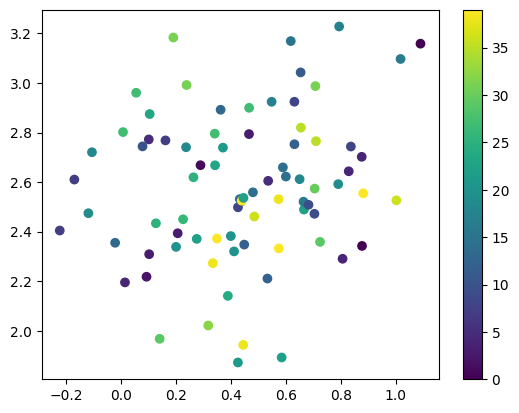

In [ ]:
embeddings = base_network.predict(X_test)
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()